In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision as tv
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms 
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import itertools

#Load the data used for training
training_data = datasets.STL10(
    root='/data/torchvision',
    split='train',
    transform=transforms.ToTensor(),
)

#Load the data used for testing
test_data = datasets.STL10(
    root='/data/torchvision',
    split='test',
    transform=transforms.ToTensor(),
)

#define the batch size
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

0
torch.Size([3, 96, 96])


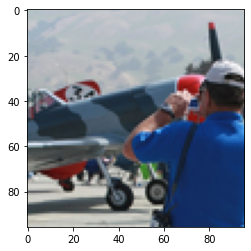

In [2]:
# train_data_gray = []

# for dataset in training_data:
#     tensorimg, label = dataset
    
#     #img = np.array(tensorimg).transpose((1,2,0))
    
#     grayimage = tv.transforms.functional.rgb_to_grayscale(tensorimg, 1)
#     train_data_gray.append((grayimage, label))
    
entry = training_data
img = np.array(entry[2000][0]).transpose((1,2,0))
plt.imshow(img, cmap='gray')
print(entry[2000][1])
print(entry[2000][0].shape)

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))
        # input 96x96, output 48x48
        self.layer2 = nn.Sequential(nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))
        # output 24x24
        self.layer3 = nn.Sequential(nn.Conv2d(12, 18, kernel_size=3, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))
        # output 12x12
        self.layer4 = nn.Sequential(nn.Conv2d(18, 24, kernel_size=3, stride=1, padding=0), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))
        # output 10x10, 5x5
        self.fc = nn.Linear(600, 300)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(300, 80)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(80, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu1(out)
        out = self.fc1(out)
        out = self.relu2(out)
        out = self.fc2(out)
        return out
    

# print(model)

Using cuda device


In [4]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [5]:
def test(dataloader, model, loss_fn, epoch_loss, epoch_acc):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    epoch_loss.append(test_loss)
    epoch_acc.append(100*correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [6]:
def test_with_confusion_matrix(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            predicted_labels = pred.argmax(1)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(y.cpu().numpy())
            correct += (predicted_labels == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return np.array(true_labels), np.array(predictions)

In [7]:
# model = LeNet().to(device)
# learningrate = 0.1

# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learningrate)
# epochs = 30
# epoch_loss = []
# epoch_acc = []
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train(train_dataloader, model, loss_fn, optimizer)
#     test(test_dataloader, model, loss_fn, epoch_loss, epoch_acc)
# print("Done!")

# epoch_loss = np.array(epoch_loss)
# epoch_acc = np.array(epoch_acc)
# _, ax_loss = plt.subplots(dpi=150)
# ax_loss.plot(np.arange(epoch_loss.shape[0]), epoch_loss, c='C0', label='Loss')
# ax_loss.set_xlabel('Epoche')
# ax_loss.set_ylabel('Loss')
# ax_acc = ax_loss.twinx()
# ax_acc.plot(np.arange(epoch_loss.shape[0]), epoch_acc, c='C1', label='Genauigkeit')
# _ = ax_acc.set_ylabel('Genauigkeit')
# hloss, lloss = ax_loss.get_legend_handles_labels()
# hacc, lacc = ax_acc.get_legend_handles_labels()
# ax_loss.legend(hloss + hacc, lloss + lacc, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

In [8]:
model = LeNet().to(device)
learningrate = 0.1

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningrate)
epochs = 20
epoch_loss = []
epoch_acc = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    true_labels, predicted_labels = test_with_confusion_matrix(test_dataloader, model, loss_fn)
#     epoch_loss.append(loss.item())
#     epoch_acc.append(correct)


Epoch 1
-------------------------------
loss: 2.314116  [   64/ 5000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.302636 

Epoch 2
-------------------------------
loss: 2.307229  [   64/ 5000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.302223 

Epoch 3
-------------------------------
loss: 2.304627  [   64/ 5000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.301554 

Epoch 4
-------------------------------
loss: 2.303106  [   64/ 5000]
Test Error: 
 Accuracy: 11.5%, Avg loss: 2.299753 

Epoch 5
-------------------------------
loss: 2.300965  [   64/ 5000]
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.293771 

Epoch 6
-------------------------------
loss: 2.294369  [   64/ 5000]
Test Error: 
 Accuracy: 10.5%, Avg loss: 2.310024 

Epoch 7
-------------------------------
loss: 2.310612  [   64/ 5000]
Test Error: 
 Accuracy: 18.0%, Avg loss: 2.221838 

Epoch 8
-------------------------------
loss: 2.213784  [   64/ 5000]
Test Error: 
 Accuracy: 16.7%, Avg loss: 2.346827 

Epoch 9
----------------

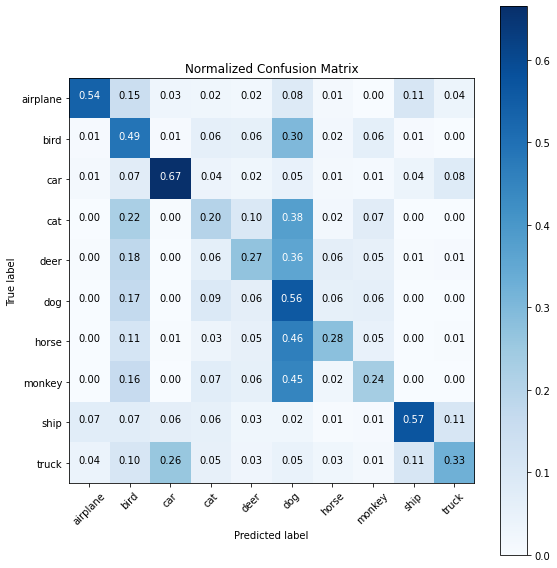

In [9]:

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_labels = [
    'airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'
]
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Use white text if cells are dark; otherwise, use black text
thresh = cm_normalized.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm_normalized[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if cm_normalized[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()